In [4]:
import pandas as pd
import numpy as np
from mrmr import mrmr_classif
bkg = pd.read_csv(r"C:\Users\ahnec\Downloads\background_train.csv")
sig = pd.read_csv(r"C:\Users\ahnec\Downloads\signal_train.csv")

#remove labels exclusive to one dataset
colsToRemove = set(np.concatenate([list(set(sig.columns)-set(bkg.columns)), list(set(bkg.columns)-set(sig.columns))]))


bkg.drop(columns=colsToRemove, inplace = True)
sig.drop(columns=colsToRemove, inplace = True)

bkg.columns, sig.columns

(Index(['CorsikaWeightMap.AreaSum', 'CorsikaWeightMap.Atmosphere',
        'CorsikaWeightMap.CylinderLength', 'CorsikaWeightMap.CylinderRadius',
        'CorsikaWeightMap.DiplopiaWeight', 'CorsikaWeightMap.EnergyPrimaryMax',
        'CorsikaWeightMap.EnergyPrimaryMin', 'CorsikaWeightMap.FluxSum',
        'CorsikaWeightMap.Multiplicity', 'CorsikaWeightMap.SpectralIndexChange',
        ...
        'NewAtt.DirectEllipse', 'NewAtt.DeltaZd', 'NewAtt.AbsSmooth',
        'NewAtt.emptyness', 'NewAtt.SepDevide', 'NewAtt.SPEBayVerRadius',
        'NewAtt.SplineVerRadius', 'CorsikaWeightMap.ParticleType',
        'CorsikaWeightMap.Polygonato', 'CorsikaWeightMap.PrimarySpectralIndex'],
       dtype='object', length=283),
 Index(['CorsikaWeightMap.AreaSum', 'CorsikaWeightMap.Atmosphere',
        'CorsikaWeightMap.CylinderLength', 'CorsikaWeightMap.CylinderRadius',
        'CorsikaWeightMap.DiplopiaWeight', 'CorsikaWeightMap.EnergyPrimaryMax',
        'CorsikaWeightMap.EnergyPrimaryMin', 'CorsikaWei

In [5]:
#remove non value rows
bkg.replace([np.inf, -np.inf], np.nan, inplace=True)
sig.replace([np.inf, -np.inf], np.nan, inplace=True)
#Columns with above 10% nan/inf get dropped all other nan/inf rows are dropped
for col in bkg.columns:
    bkgNaRatio = np.sum(bkg[col].isna())/len(bkg)
    sigNaRatio = np.sum(sig[col].isna())/len(sig)
    maxNaRatio = max(bkgNaRatio, sigNaRatio)
    if maxNaRatio > .1:
        bkg.drop(columns = col, inplace = True)
        sig.drop(columns = col, inplace = True)
bkg.dropna(inplace = True)
sig.dropna(inplace = True)
#Remove MC truths
truthList = ['MC', 'Weight', 'Corsika', 'I3EventHeader']
for col in bkg.columns:
    if any(sg in col for sg in truthList):
        bkg.drop(columns = col, inplace = True)
        sig.drop(columns = col, inplace = True)
#Combine Datasets
bkg['label'] = 0
sig['label'] = 1
df = pd.concat([bkg,sig])

df['label']

0        0
1        0
2        0
3        0
4        0
        ..
17928    1
17929    1
17930    1
17931    1
17932    1
Name: label, Length: 35652, dtype: int64

In [6]:
#Feature Selection arbitrarlily choose k=33
selected_features = mrmr_classif(X=df.drop(columns=['label']), y=df['label'], K=33)

100%|██████████| 33/33 [00:16<00:00,  2.00it/s]


In [7]:
#export trainging Dataset
export_features = np.append(selected_features, 'label')
export_features

array(['LineFit_TTParams.lf_vel_z', 'HitStatisticsValues.max_pulse_time',
       'SplineMPEFitParams.rlogl', 'HitStatisticsValues.z_travel',
       'SplineMPEDirectHitsA.n_dir_strings', 'LineFit_TT.zenith',
       'NewAtt.DeltaZd', 'MuEXAngular4.zenith', 'NewAtt.SplineVerRadius',
       'SplineMPEDirectHitsA.n_dir_doms', 'MPEFitHighNoise.zenith',
       'MuEXAngular4_Sigma.value', 'SPEFit2_TT.zenith',
       'MPEFit_TTFitParams.rlogl', 'SplineMPE.zenith',
       'SplineMPEDirectHitsC.dir_track_length',
       'SplineMPEMuEXDifferential.zenith',
       'SplineMPETruncatedEnergy_SPICEMie_AllBINS_Muon.zenith',
       'NewAtt.radius', 'SplineMPECharacteristics.avg_dom_dist_q_tot_dom',
       'SplineMPETruncatedEnergy_SPICEMie_AllDOMS_Muon.zenith',
       'MPEFitHighNoiseFitParams.rlogl', 'MPEFit_TT.zenith',
       'MPEFitParaboloid.zenith',
       'SplineMPETruncatedEnergy_SPICEMie_AllBINS_MuEres.value',
       'MPEFitParaboloidFitParams.zenith',
       'SplineMPETruncatedEnergy_SPICEMie_A

In [8]:
import os

# Define the directory and file path
directory = 'build'
file_name = 'final_predictions.csv'
full_path = os.path.join(directory, file_name)

# Check if the directory exists, and if not, create it
if not os.path.exists(directory):
    os.makedirs(directory)

df.to_csv('build/training_data.csv', columns = export_features)

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn import metrics
import xgboost as xgb

In [10]:
#Import training and validation data
df = pd.read_csv('build/training_data.csv')
lbl = df['label']
df = df.drop(columns='label')

Xtrain,Xtest, ytrain, ytest = train_test_split(df, lbl, test_size = 0.3, random_state = 555)
df

,Unnamed: 0,LineFit_TTParams.lf_vel_z,HitStatisticsValues.max_pulse_time,SplineMPEFitParams.rlogl,HitStatisticsValues.z_travel,SplineMPEDirectHitsA.n_dir_strings,LineFit_TT.zenith,NewAtt.DeltaZd,MuEXAngular4.zenith,NewAtt.SplineVerRadius,...,MPEFitParaboloid.zenith,SplineMPETruncatedEnergy_SPICEMie_AllBINS_MuEres.value,MPEFitParaboloidFitParams.zenith,SplineMPETruncatedEnergy_SPICEMie_AllDOMS_MuEres.value,SPEFit2Bayesian.z,SplineMPECharacteristics.track_hits_separation_length,SplineMPEDirectHitsC.n_dir_doms,LineFit_TTParams.lf_vel,HitStatisticsValues.z_min,MPEFitParaboloidFitParams.err1
0,0,0.096287,11562.126953,10.367244,24.109411,2.0,1.960378,0.026920,1.928833,512.131798,...,1.933928,0.467407,1.933928,0.499311,80.936164,80.903746,5.0,0.253519,24.900000,0.065920
1,1,-0.005039,11123.472656,10.400910,-6.289331,1.0,1.552397,0.048566,1.597158,518.199752,...,1.600047,0.467407,1.600047,0.451037,511.046096,133.643512,5.0,0.273855,411.839996,0.050926
2,2,-0.038434,11696.294922,10.299522,-21.047453,0.0,1.425490,0.086434,1.522798,160.688747,...,1.528091,0.467407,1.528091,0.499311,450.663319,220.519899,5.0,0.265440,398.850006,0.059130
3,3,0.060110,11803.718750,10.355911,63.821544,2.0,1.996007,0.321507,2.330743,480.050446,...,2.690799,0.467407,2.690799,0.499311,-336.646086,158.044505,10.0,0.145717,-485.350006,0.184114
4,4,-0.022277,12542.181641,8.970953,-4.247991,1.0,1.480177,0.174903,1.637345,143.752855,...,1.676679,0.467407,1.676679,0.451037,37.702177,321.034819,5.0,0.246164,40.500000,0.040053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35647,17928,0.129337,10940.264648,10.790305,54.303889,2.0,2.053326,0.217800,2.275019,325.801372,...,2.276741,0.467407,2.276741,0.529430,25.809960,138.129732,7.0,0.278730,-10.810000,0.104930
35648,17929,0.096921,11888.145508,8.593457,65.840907,2.0,1.891245,0.006878,1.893658,376.414197,...,1.911301,0.378125,1.911301,0.499311,380.117496,338.086471,7.0,0.307692,331.600006,0.015774
35649,17930,-0.002848,11764.501953,8.098555,-1.645002,3.0,1.559774,0.030703,1.542472,312.563673,...,1.530017,0.378125,1.530017,0.473491,-176.184763,227.499373,8.0,0.258393,-193.440002,0.015564
35650,17931,0.089573,11319.460938,8.002074,46.581677,2.0,1.878569,0.011253,1.873545,335.954455,...,1.862003,0.378125,1.862003,0.397956,-608.913607,225.166288,8.0,0.295682,-467.519989,0.039250


In [11]:
#Implementing training function with stratifiesKFold
def trainModel(X,y,k = 5):
    skf = StratifiedKFold(n_splits=k, random_state=555, shuffle=True)
    model = []
    for _, (train_index, test_index) in zip(tqdm(range(k)), skf.split(X, y)):
        bdt = xgb.XGBClassifier(tree_method='hist', random_state=555, objective='binary:logistic'
                              , early_stopping_rounds=10, eval_metric=["logloss"])
        
        bdt.fit(X.to_numpy()[train_index], y.to_numpy()[train_index],
                eval_set=[(X.to_numpy()[test_index], y.to_numpy()[test_index])]);
        model.append(bdt)
    return model

model = trainModel(Xtrain,ytrain, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

[0]	validation_0-logloss:0.49654
[1]	validation_0-logloss:0.38154
[2]	validation_0-logloss:0.30782
[3]	validation_0-logloss:0.25640
[4]	validation_0-logloss:0.22069
[5]	validation_0-logloss:0.19411
[6]	validation_0-logloss:0.17329
[7]	validation_0-logloss:0.15717
[8]	validation_0-logloss:0.14562
[9]	validation_0-logloss:0.13742
[10]	validation_0-logloss:0.13080
[11]	validation_0-logloss:0.12573
[12]	validation_0-logloss:0.12036
[13]	validation_0-logloss:0.11680
[14]	validation_0-logloss:0.11419
[15]	validation_0-logloss:0.11095
[16]	validation_0-logloss:0.10901
[17]	validation_0-logloss:0.10816
[18]	validation_0-logloss:0.10667
[19]	validation_0-logloss:0.10453
[20]	validation_0-logloss:0.10409
[21]	validation_0-logloss:0.10362
[22]	validation_0-logloss:0.10274
[23]	validation_0-logloss:0.10209
[24]	validation_0-logloss:0.10222
[25]	validation_0-logloss:0.10174
[26]	validation_0-logloss:0.10022
[27]	validation_0-logloss:0.09965
[28]	validation_0-logloss:0.09907
[29]	validation_0-loglos

 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

[0]	validation_0-logloss:0.49915
[1]	validation_0-logloss:0.38534
[2]	validation_0-logloss:0.31045
[3]	validation_0-logloss:0.26012
[4]	validation_0-logloss:0.22254
[5]	validation_0-logloss:0.19538
[6]	validation_0-logloss:0.17676
[7]	validation_0-logloss:0.16077
[8]	validation_0-logloss:0.14873
[9]	validation_0-logloss:0.13935
[10]	validation_0-logloss:0.13294
[11]	validation_0-logloss:0.12750
[12]	validation_0-logloss:0.12333
[13]	validation_0-logloss:0.11953
[14]	validation_0-logloss:0.11552
[15]	validation_0-logloss:0.11354
[16]	validation_0-logloss:0.11098
[17]	validation_0-logloss:0.10891
[18]	validation_0-logloss:0.10705
[19]	validation_0-logloss:0.10611
[20]	validation_0-logloss:0.10496
[21]	validation_0-logloss:0.10406
[22]	validation_0-logloss:0.10363
[23]	validation_0-logloss:0.10248
[24]	validation_0-logloss:0.10244
[25]	validation_0-logloss:0.10202
[26]	validation_0-logloss:0.10145
[27]	validation_0-logloss:0.10105
[28]	validation_0-logloss:0.10096
[29]	validation_0-loglos

 40%|████      | 2/5 [00:01<00:02,  1.16it/s]

[0]	validation_0-logloss:0.49688
[1]	validation_0-logloss:0.37964
[2]	validation_0-logloss:0.30595
[3]	validation_0-logloss:0.25529
[4]	validation_0-logloss:0.21658
[5]	validation_0-logloss:0.18906
[6]	validation_0-logloss:0.16891
[7]	validation_0-logloss:0.15308
[8]	validation_0-logloss:0.14069
[9]	validation_0-logloss:0.13004
[10]	validation_0-logloss:0.12207
[11]	validation_0-logloss:0.11671
[12]	validation_0-logloss:0.11236
[13]	validation_0-logloss:0.10765
[14]	validation_0-logloss:0.10457
[15]	validation_0-logloss:0.10178
[16]	validation_0-logloss:0.09924
[17]	validation_0-logloss:0.09737
[18]	validation_0-logloss:0.09577
[19]	validation_0-logloss:0.09440
[20]	validation_0-logloss:0.09369
[21]	validation_0-logloss:0.09253
[22]	validation_0-logloss:0.09188
[23]	validation_0-logloss:0.09048
[24]	validation_0-logloss:0.08994
[25]	validation_0-logloss:0.08897
[26]	validation_0-logloss:0.08801
[27]	validation_0-logloss:0.08705
[28]	validation_0-logloss:0.08658
[29]	validation_0-loglos

 60%|██████    | 3/5 [00:02<00:01,  1.11it/s]

[0]	validation_0-logloss:0.49566
[1]	validation_0-logloss:0.38096
[2]	validation_0-logloss:0.30691
[3]	validation_0-logloss:0.25700
[4]	validation_0-logloss:0.21941
[5]	validation_0-logloss:0.19335
[6]	validation_0-logloss:0.17330
[7]	validation_0-logloss:0.15618
[8]	validation_0-logloss:0.14462
[9]	validation_0-logloss:0.13547
[10]	validation_0-logloss:0.12839
[11]	validation_0-logloss:0.12312
[12]	validation_0-logloss:0.11887
[13]	validation_0-logloss:0.11490
[14]	validation_0-logloss:0.11219
[15]	validation_0-logloss:0.10925
[16]	validation_0-logloss:0.10707
[17]	validation_0-logloss:0.10573
[18]	validation_0-logloss:0.10293
[19]	validation_0-logloss:0.10158
[20]	validation_0-logloss:0.10093
[21]	validation_0-logloss:0.09992
[22]	validation_0-logloss:0.09895
[23]	validation_0-logloss:0.09847
[24]	validation_0-logloss:0.09804
[25]	validation_0-logloss:0.09738
[26]	validation_0-logloss:0.09683
[27]	validation_0-logloss:0.09599
[28]	validation_0-logloss:0.09588
[29]	validation_0-loglos

 80%|████████  | 4/5 [00:03<00:00,  1.04it/s]

[0]	validation_0-logloss:0.49863
[1]	validation_0-logloss:0.38195
[2]	validation_0-logloss:0.30823
[3]	validation_0-logloss:0.25641
[4]	validation_0-logloss:0.21891
[5]	validation_0-logloss:0.19051
[6]	validation_0-logloss:0.17039
[7]	validation_0-logloss:0.15445
[8]	validation_0-logloss:0.14326
[9]	validation_0-logloss:0.13491
[10]	validation_0-logloss:0.12663
[11]	validation_0-logloss:0.12098
[12]	validation_0-logloss:0.11600
[13]	validation_0-logloss:0.11192
[14]	validation_0-logloss:0.10820
[15]	validation_0-logloss:0.10605
[16]	validation_0-logloss:0.10294
[17]	validation_0-logloss:0.10088
[18]	validation_0-logloss:0.09914
[19]	validation_0-logloss:0.09842
[20]	validation_0-logloss:0.09606
[21]	validation_0-logloss:0.09455
[22]	validation_0-logloss:0.09420
[23]	validation_0-logloss:0.09364
[24]	validation_0-logloss:0.09285
[25]	validation_0-logloss:0.09227
[26]	validation_0-logloss:0.09135
[27]	validation_0-logloss:0.09087
[28]	validation_0-logloss:0.08966
[29]	validation_0-loglos

100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


In [17]:
#Implementing prediction
def predict(model, X):
    res = []
    for m in model:
        res.append(m.predict_proba(X)[:,1])
    return np.mean(res, axis = 0)

ypred = predict(model, Xtest.to_numpy())
ypred

array([2.2522206e-04, 9.9980611e-01, 3.3993616e-03, ..., 9.9649560e-01,
       6.3329506e-01, 9.9985284e-01], dtype=float32)

0.9955077181593477


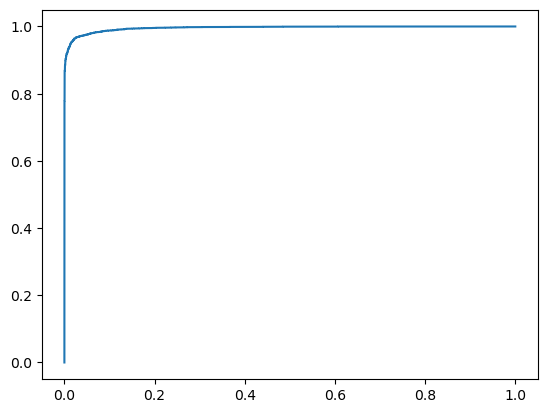

In [18]:
#Calc ROC,AUC curve
fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred)
plt.plot(fpr,tpr);
AUC = metrics.roc_auc_score(ytest, ypred)
print(AUC)

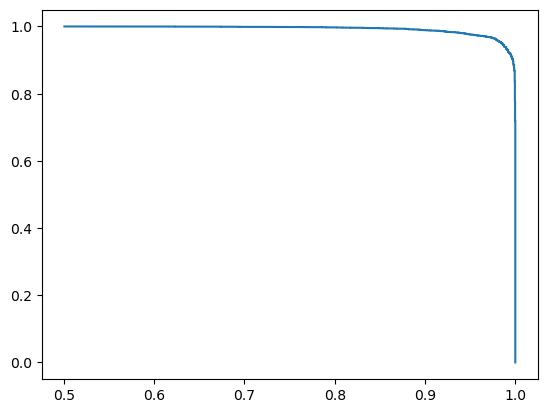

In [19]:
#save ROC,AUC curve to disk
file = open('build/BdtRoc.txt', 'w')
file.write('#fpr tpr\n')
for f, t in zip(fpr, tpr):
    file.write(f'{f} {t}\n')
file.write(f'-1 {AUC}')
file.close()
#Calc Precision Recall curve
prec, rec, thresh = metrics.precision_recall_curve(ytest, ypred)

plt.plot(prec, rec)

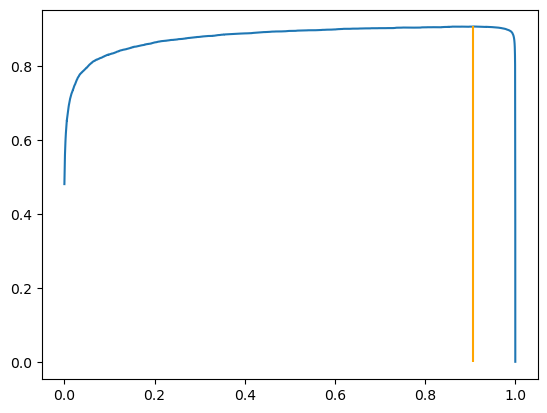

In [20]:
#Find Threshold with fbeta score
def fbeta(p, r, beta = 0.1):
    return (1+beta**2)*(p*r)/(beta*p+r)

fb = fbeta(prec, rec)[:-1]
argTr = np.argmax(fb)
plt.plot(thresh, fb)
plt.vlines(thresh[argTr], 0, fb[argTr], color = 'orange', label = 'peak')

In [21]:
#classify test data
dftest = pd.read_csv('test.csv', usecols = df.columns).reindex(columns = df.columns)


ypred_test = predict(model, dftest)

threshold = thresh[argTr]
ycls = ypred_test > threshold
ycls = [1 if i else 0 for i in ycls]
#save ROC,AUC and fbeta curve to disk
file = open('build/BdtPRC.txt', 'w')
file.write('#Precision Recal\n')
for f, t,b in zip(prec[:-1], rec[:-1], fb):
    file.write(f'{f} {t} {b}\n')
file.close()
#save predictions
file = open('build/BdtClassified.txt', 'w')
file.write('#label\n')
for f in ycls:
    file.write(f'{f}\n')
file.close()

FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'

In [22]:
cols = Xtrain.columns

In [23]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [24]:
Xtrain = pd.DataFrame(Xtrain, columns=[cols])
Xtest = pd.DataFrame(Xtest, columns=[cols])
Xtrain.head()

,Unnamed: 0,LineFit_TTParams.lf_vel_z,HitStatisticsValues.max_pulse_time,SplineMPEFitParams.rlogl,HitStatisticsValues.z_travel,SplineMPEDirectHitsA.n_dir_strings,LineFit_TT.zenith,NewAtt.DeltaZd,MuEXAngular4.zenith,NewAtt.SplineVerRadius,...,MPEFitParaboloid.zenith,SplineMPETruncatedEnergy_SPICEMie_AllBINS_MuEres.value,MPEFitParaboloidFitParams.zenith,SplineMPETruncatedEnergy_SPICEMie_AllDOMS_MuEres.value,SPEFit2Bayesian.z,SplineMPECharacteristics.track_hits_separation_length,SplineMPEDirectHitsC.n_dir_doms,LineFit_TTParams.lf_vel,HitStatisticsValues.z_min,MPEFitParaboloidFitParams.err1
0,0.753207,-0.211006,0.553749,-0.364900,-0.085456,0.0,-0.228440,-0.100315,-0.333659,-0.136844,...,-0.371632,0.000000,-0.372094,0.194269,-0.659798,0.196943,0.2,-1.143930,-0.610436,0.277687
1,0.170434,1.246301,1.177210,-1.053680,2.334947,0.5,1.136484,-0.553095,1.167480,0.096505,...,1.144856,-1.155314,1.145065,-1.132757,-0.427227,2.195902,2.6,0.448321,-0.607332,-0.698622
2,-0.463986,0.463925,-0.814734,0.354406,0.495084,0.5,0.403475,0.117169,0.277958,0.426383,...,0.281269,0.613575,0.281095,-0.170974,0.516773,-0.021439,-0.4,-0.067697,0.541460,0.194762
3,0.972899,-0.469679,-1.036950,0.645449,-0.412398,0.0,-0.425303,0.320919,-0.389456,0.504938,...,-0.355249,0.000000,-0.355704,0.417655,0.576288,0.624686,-0.6,0.646970,0.585173,0.017439
4,-0.651025,0.224673,0.366071,-0.449557,0.527897,1.0,0.133452,-0.495445,0.081970,-1.163848,...,0.087866,-0.862901,0.087606,-0.977443,0.019231,1.180383,0.8,0.508021,0.077047,-0.660584


In [25]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)

GaussianNB()

In [26]:
ypred = gnb.predict(Xtest)

ypred

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [27]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(ytest, ypred)))

Model accuracy score: 0.8391


In [28]:
ypredtrain = gnb.predict(Xtrain)

ypredtrain

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

In [29]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(ytrain, ypredtrain)))

Training-set accuracy score: 0.8328


In [30]:
print('Training set score: {:.4f}'.format(gnb.score(Xtrain, ytrain)))

print('Test set score: {:.4f}'.format(gnb.score(Xtest, ytest)))

Training set score: 0.8328
Test set score: 0.8391


In [31]:
ytest.value_counts()

label
1    5355
0    5341
Name: count, dtype: int64

In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ytest, ypred)

print('Confusion matrix\n\n', cm)

print('\nBackground(Actual) = ', cm[0,0])

print('\nSignal(Predicted) = ', cm[1,1])

print('\nBackground(Predicted) = ', cm[0,1])

print('\nSignal(Actual) = ', cm[1,0])

Confusion matrix

 [[4816  525]
 [1196 4159]]

Background(Actual) =  4816

Signal(Predicted) =  4159

Background(Predicted) =  525

Signal(Actual) =  1196


<Axes: >

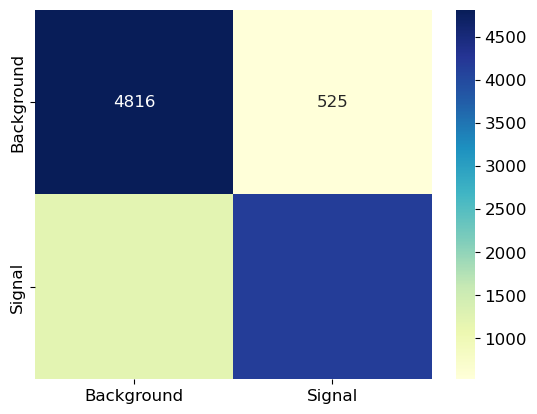

In [40]:
import seaborn as sns
cm_matrix = pd.DataFrame(data=cm, columns=['Background', 'Signal'], 
                                 index=['Background', 'Signal'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [42]:
from sklearn.metrics import classification_report

print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      5341
           1       0.89      0.78      0.83      5355

    accuracy                           0.84     10696
   macro avg       0.84      0.84      0.84     10696
weighted avg       0.84      0.84      0.84     10696



In [43]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [44]:
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

Classification accuracy : 0.8391


In [47]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))

Classification error : 0.1609


In [49]:
precision = TP / float(TP + FP)

print('Precision : {0:0.4f}'.format(precision))

Precision : 0.9017


In [50]:
recall = TP / float(TP + FN)

print('Recall or Sensitivity : {0:0.4f}'.format(recall))

Recall or Sensitivity : 0.8011


In [69]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(Xtrain, ytrain)

KNeighborsClassifier(n_neighbors=3)

In [71]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(ytest, ypred2)))

Model accuracy score: 0.9426


In [57]:
ypred2train = knn.predict(Xtrain)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(ytrain, ypred2train)))

Training-set accuracy score: 0.9655


In [59]:
# the model with k=5
knn5 = KNeighborsClassifier(n_neighbors=5)


# fit the model to the training set
knn5.fit(Xtrain, ytrain)


# predict on the test-set
ypred5 = knn5.predict(Xtest)


print('Model accuracy score with k=5 : {0:0.4f}'. format(accuracy_score(ytest, ypred5)))

Model accuracy score with k=5 : 0.9447


In [60]:
# the model with k=6
knn6 = KNeighborsClassifier(n_neighbors=6)


# fit the model to the training set
knn6.fit(Xtrain, ytrain)


# predict on the test-set
ypred6 = knn6.predict(Xtest)


print('Model accuracy score with k=6 : {0:0.4f}'. format(accuracy_score(ytest, ypred6)))

Model accuracy score with k=6 : 0.9459


In [62]:
# the model with k=7
knn7 = KNeighborsClassifier(n_neighbors=7)


# fit the model to the training set
knn7.fit(Xtrain, ytrain)


# predict on the test-set
ypred7 = knn7.predict(Xtest)


print('Model accuracy score with k=7 : {0:0.4f}'. format(accuracy_score(ytest, ypred7)))

Model accuracy score with k=7 : 0.9462


In [63]:
# the model with k=8
knn8 = KNeighborsClassifier(n_neighbors=8)


# fit the model to the training set
knn8.fit(Xtrain, ytrain)


# predict on the test-set
ypred8 = knn8.predict(Xtest)


print('Model accuracy score with k=8 : {0:0.4f}'. format(accuracy_score(ytest, ypred8)))

Model accuracy score with k=8 : 0.9444


In [79]:
# The Confusion Matrix with k=8

cm = confusion_matrix(ytest, ypred8)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[5192  149]
 [ 446 4909]]

True Positives(TP) =  5192

True Negatives(TN) =  4909

False Positives(FP) =  149

False Negatives(FN) =  446


<Axes: >

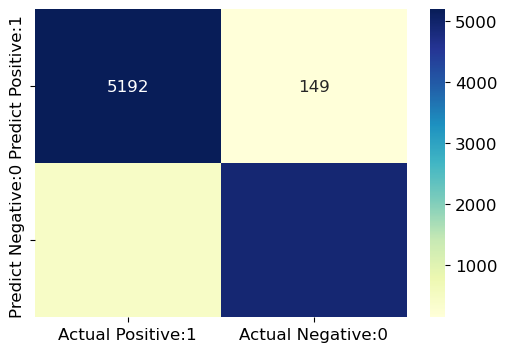

In [80]:
plt.figure(figsize=(6,4))

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [82]:
print(classification_report(ytest, ypred8))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      5341
           1       0.97      0.92      0.94      5355

    accuracy                           0.94     10696
   macro avg       0.95      0.94      0.94     10696
weighted avg       0.95      0.94      0.94     10696

